In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd
import copy

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")

In [3]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [4]:
do18 = []
precip = []
temp = []
for i in range(len(t)):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])

In [9]:
def divide_data(temp: pd.DataFrame, precip: pd.DataFrame, do18: pd.DataFrame, train=0.9, random=True):
    
    if random:
        random_idx = np.random.permutation(do18.index.values)
    
        temp = temp.reindex(random_idx)
        precip = precip.reindex(random_idx)
        do18 = do18.reindex(random_idx)
    
    #divide training and test data
    do18_train = do18[:int(np.floor(train*len(do18)))].reset_index(drop=True)
    do18_test = do18[int(np.floor(train*len(do18))):].reset_index(drop=True)

    temp_train = temp[:int(np.floor(train*len(temp)))].reset_index(drop=True)
    temp_test = temp[int(np.floor(train*len(temp))):].reset_index(drop=True)

    precip_train = precip[:int(np.floor(train*len(precip)))].reset_index(drop=True)
    precip_test = precip[int(np.floor(train*len(precip))):].reset_index(drop=True)
    
    return do18_train, do18_test, temp_train, temp_test, precip_train, precip_test

In [10]:
def mlr(
    temp: pd.DataFrame, precip: pd.DataFrame, do18: pd.DataFrame, 
    train_proportion=0.9, random=True):
    
    do18_train, do18_test, temp_train, temp_test, precip_train, precip_test = divide_data(
        temp, precip, do18, train_proportion, random
    )
    
    X_train = np.append(temp_train, precip_train, axis=1)
    X_test = np.append(temp_test, precip_test, axis=1)

    Y_train = do18_train
    Y_test = pd.DataFrame(do18_test)
        
    #train model
    regressor = LinearRegression().fit(X_train, Y_train)
    #Random Forest Regression: 
    #regressor = RandomForestRegressor().fit(X_train, Y_train.values.ravel())
    
    #predict test data
    pred = pd.DataFrame(regressor.predict(X_test))
    
    #return predictions and test data
    return pred, Y_test

In [11]:
pred, Y_test = mlr(temp, precip, do18)

In [13]:
pred

,0,1,2,3,4,5,6,7,8,9,...,6806,6807,6808,6809,6810,6811,6812,6813,6814,6815
0,-18.026506,-18.058661,-18.001805,-17.909091,-17.923856,-17.957241,-17.974405,-17.971576,-18.089329,-18.465632,...,-51.247419,-50.603360,-51.465545,-52.523475,-53.035771,-53.510167,-53.835817,-54.381601,-55.188436,-55.873619
1,-20.900106,-20.808673,-20.522590,-20.407483,-20.533920,-20.601919,-20.586189,-20.666062,-20.635871,-20.572800,...,-50.262769,-50.245744,-50.651044,-51.714836,-52.323965,-53.666875,-54.397810,-55.408960,-56.486792,-57.577023
2,-17.738450,-17.657120,-17.758955,-17.759673,-17.605163,-17.475841,-17.474593,-17.406288,-17.795056,-18.069134,...,-53.100217,-53.651795,-54.685389,-56.053655,-56.580560,-57.059697,-57.702083,-58.193188,-59.173789,-60.241257
3,-17.397924,-17.487487,-17.521223,-17.322562,-17.509105,-17.553054,-17.663086,-17.839709,-17.746672,-17.620720,...,-51.304280,-51.191733,-52.169294,-53.829669,-54.903308,-55.890884,-56.109770,-56.460493,-56.705553,-56.742897
4,-16.228557,-16.399900,-16.724798,-16.799218,-17.060573,-17.152455,-17.234513,-17.227630,-17.623292,-17.947129,...,-50.465592,-50.845295,-52.323148,-53.213637,-53.187681,-53.732724,-53.771485,-53.905949,-54.296948,-54.222348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-18.135018,-18.103057,-18.245745,-18.369637,-18.427315,-18.701109,-18.618129,-18.267059,-18.227077,-18.565226,...,-52.799018,-52.924529,-53.648359,-54.815328,-55.836746,-56.148162,-56.578581,-56.448581,-56.779854,-57.801579
96,-18.473641,-18.181590,-18.418613,-18.690709,-18.368532,-18.326684,-18.390618,-18.554975,-18.473816,-18.150944,...,-51.322023,-51.222769,-52.064732,-53.095515,-53.403856,-53.494862,-53.863610,-54.071210,-54.632257,-55.061649
97,-20.000910,-20.146052,-20.752406,-21.025625,-21.195277,-21.094808,-21.438990,-21.600540,-21.852438,-21.597644,...,-50.730147,-51.058621,-51.943449,-52.915724,-53.532427,-53.957680,-54.366342,-54.711504,-54.849297,-54.727818
98,-17.347708,-16.966558,-16.760407,-16.508445,-16.413101,-16.508124,-16.505500,-16.338912,-16.113248,-16.154020,...,-52.083867,-52.308625,-53.110854,-54.541171,-55.252258,-55.911165,-56.158875,-56.940333,-57.896979,-59.305485


## Mean deviation from mean values

In [9]:
pred_list = copy.deepcopy(pred)
test_list = copy.deepcopy(Y_test)

In [10]:
for i in range(100):
    pred, Y_test = mlr(temp, precip, do18)
    pred_list = pred_list.append(pred)
    test_list = test_list.append(Y_test)

pred_list = pred_list.reset_index(drop=True)
test_list = test_list.reset_index(drop=True)

KeyboardInterrupt: 

In [13]:
pred_list

,0,1,2,3,4,5,6,7,8,9,...,6806,6807,6808,6809,6810,6811,6812,6813,6814,6815
0,-18.042176,-18.118367,-18.202039,-18.559292,-18.743833,-18.995433,-19.090916,-19.073184,-19.119648,-19.302212,...,-49.781749,-49.731734,-51.326966,-51.828266,-53.342240,-54.475188,-55.308379,-55.249799,-55.817897,-56.719990
1,-20.818309,-21.240873,-21.085537,-21.021622,-21.495371,-21.761471,-21.779517,-21.919689,-22.042831,-21.851833,...,-51.695613,-52.336172,-53.364346,-54.008305,-55.056511,-55.848806,-56.123166,-56.702992,-57.127765,-58.104039
2,-16.660385,-16.926792,-16.871979,-17.024921,-17.179506,-17.296373,-17.556867,-17.653046,-17.908762,-18.008038,...,-53.521383,-53.647050,-55.058159,-55.407711,-56.647476,-57.286189,-57.602682,-57.639565,-58.153280,-59.087139
3,-16.096352,-15.663268,-15.835042,-15.806949,-16.006103,-16.311025,-16.743124,-16.953363,-16.974557,-16.823156,...,-51.285566,-51.652094,-52.332259,-53.554346,-54.155982,-54.987567,-55.100269,-55.162722,-54.444806,-54.518744
4,-18.845619,-18.839299,-19.151486,-19.496794,-19.526597,-20.083096,-20.045863,-20.118482,-20.272352,-20.088778,...,-52.766336,-52.263683,-52.971384,-53.441630,-53.964288,-53.744299,-54.594097,-54.885808,-56.233051,-57.486593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-19.648097,-19.737572,-19.954640,-19.902531,-19.938307,-20.085947,-20.342017,-20.646199,-20.775036,-20.927010,...,-52.752663,-53.065507,-53.661299,-54.198172,-54.286714,-53.989134,-54.017458,-53.825582,-54.910587,-56.336025
96,-16.539193,-16.257269,-16.363732,-16.593458,-16.544504,-16.929714,-17.161087,-17.172095,-17.072190,-17.316340,...,-53.390626,-53.167231,-54.283489,-55.805844,-55.581261,-56.127810,-56.260698,-55.843814,-56.401816,-57.361462
97,-19.571447,-19.302251,-19.344155,-19.178495,-18.942374,-18.935816,-18.916799,-19.218830,-19.225136,-19.333594,...,-50.424574,-50.601653,-51.391198,-51.963710,-52.906791,-53.840109,-54.196908,-54.787809,-55.227135,-55.593458
98,-18.984390,-18.992283,-18.850996,-18.388945,-18.207730,-18.022445,-17.709054,-17.928684,-18.030678,-17.782138,...,-53.011561,-52.672048,-53.880463,-55.207152,-55.959751,-56.766873,-56.635431,-57.013887,-57.649355,-57.948195


In [14]:
rmse_geolist = []
for pixel in test_list.columns.values:
    rmse_pixel = mean_squared_error(pred_list[pixel].values, test_list[pixel].values, squared=False)
    rmse_geolist.append(rmse_pixel)

In [15]:
df_rmse_geolist = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))

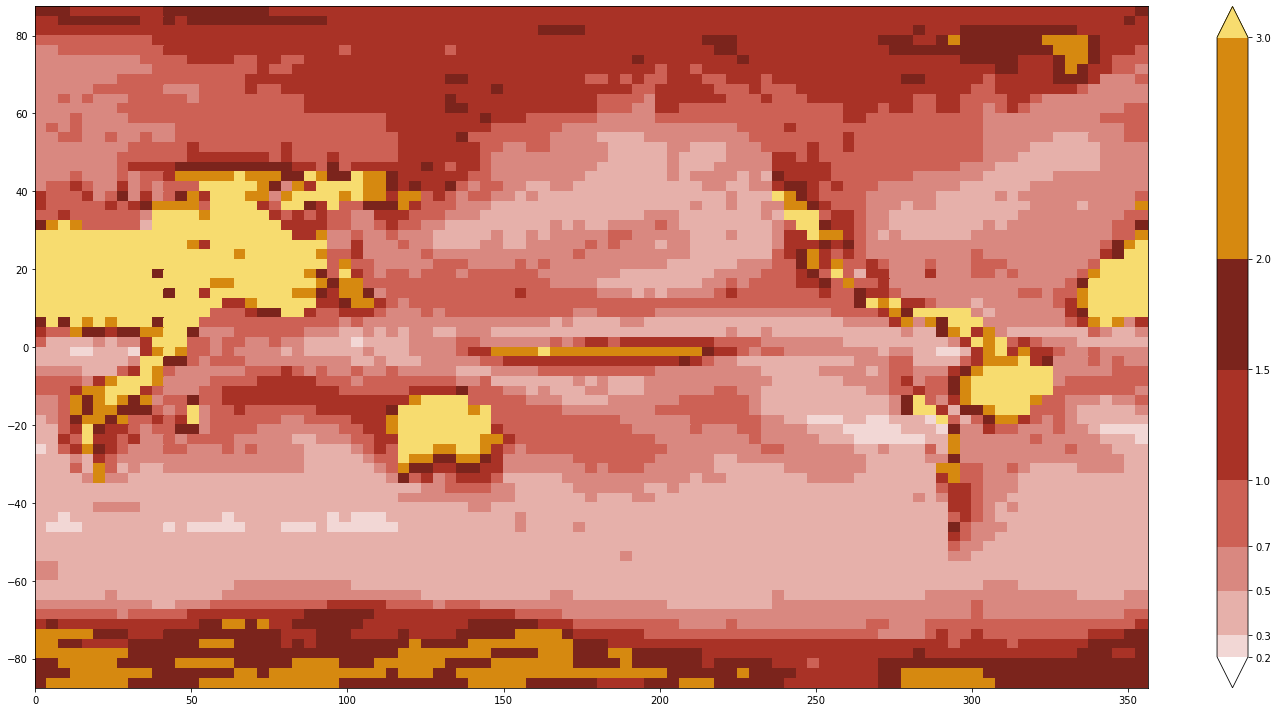

In [16]:
para = df_rmse_geolist.values

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#f2d7d5", "#e6b0aa", "#d98880", "#cd6155", "#a93226", "#7b241c", "#d68910"]
bounds = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_under("#ffffff")
cmap.set_over("#f7dc6f")
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(long, lat, para, cmap=cmap, vmin=0.1, vmax=3, norm=norm)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    extend="both", 
    ticks=bounds, 
    spacing='proportional'
)

In [17]:
file = open("rmse_mlr_gesamt.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

128920

In [18]:
std = pd.DataFrame(do18.std().values.reshape(71,96))

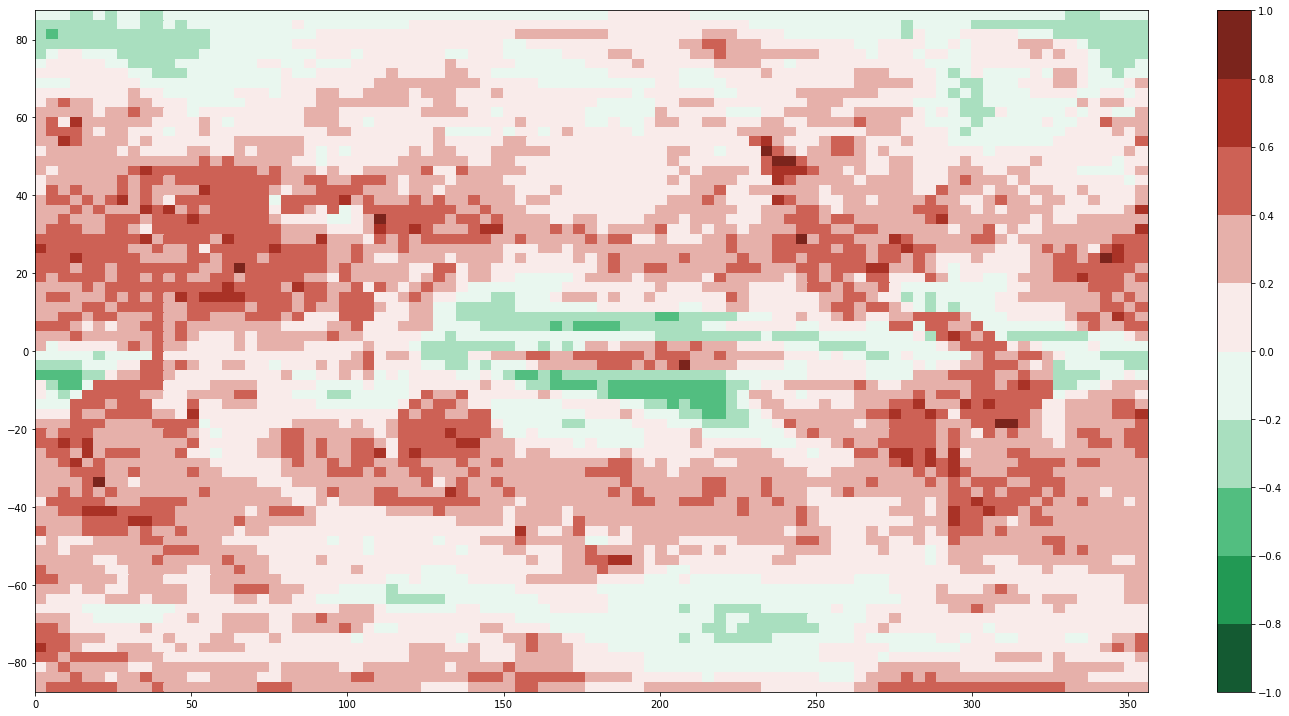

In [19]:
para = df_rmse_geolist/std -1

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#145a32", "#229954", "#52be80", "#a9dfbf",  "#e9f7ef", "#f9ebea", "#e6b0aa", "#cd6155", "#a93226", "#7b241c"]
bounds = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, para, 
    cmap=cmap,
    vmin=-1, vmax=1, 
    norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    ticks=bounds, 
    spacing='proportional'
)

In [20]:
file = open("rmse_norm_mlr_gesamt.txt", "w")
dump = "\n".join((df_rmse_geolist/std -1).values.reshape(71*96).astype(str).tolist())
file.write(dump)

135532

## Sign correlation

In [22]:
scaler = StandardScaler().fit(test_list)

In [28]:
test_list_norm = pd.DataFrame(scaler.transform(test_list))
pred_list_norm = pd.DataFrame(scaler.transform(pred_list))

In [30]:
def calculate_sign_correlation(pred_norm, do18_test_scaler):
    sign_correlation = np.heaviside(pred_norm*do18_test_scaler, 0) 
    return sign_correlation

In [32]:
sign_correlation = calculate_sign_correlation(pred_list_norm, test_list_norm)

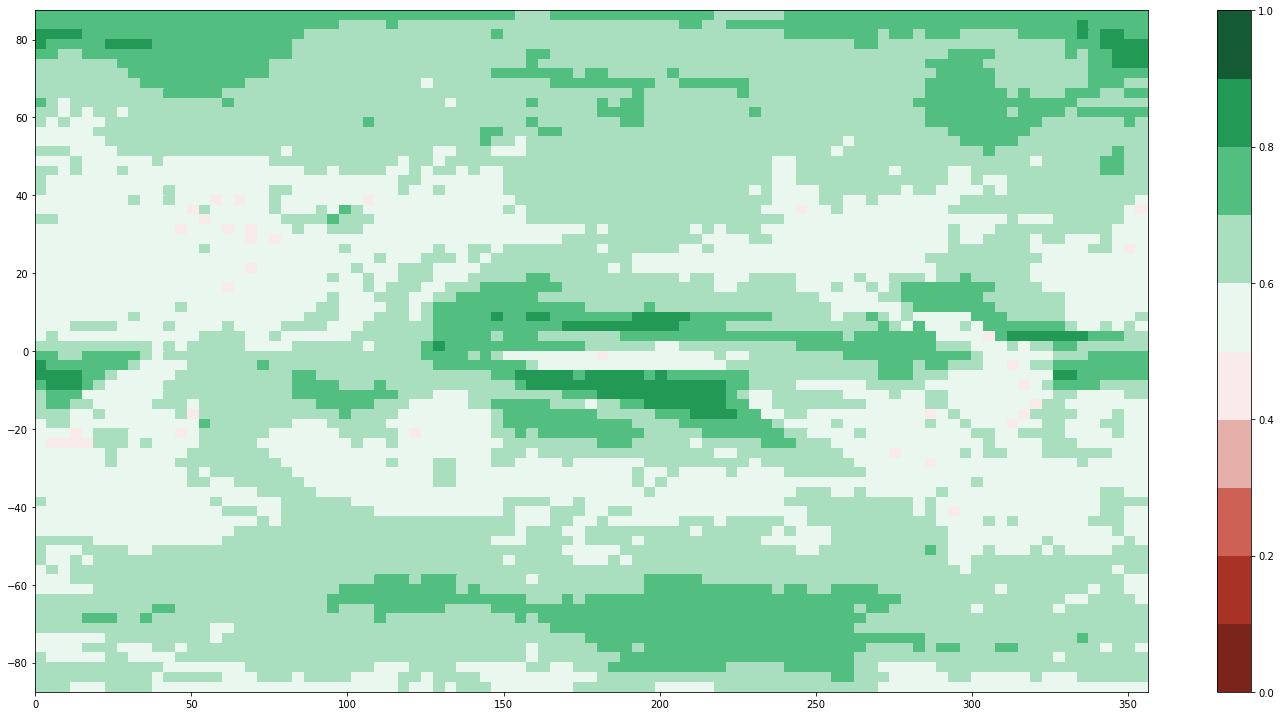

In [34]:
para = sign_correlation.mean().values.reshape(71,96)

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#7b241c", "#a93226", "#cd6155", "#e6b0aa", "#f9ebea", "#e9f7ef", "#a9dfbf", "#52be80", "#229954", "#145a32"]
cmap= matplotlib.colors.ListedColormap(colors)
norm= matplotlib.colors.Normalize(vmin=0,vmax=1)

plt.pcolor(long, lat, para,  cmap=cmap, vmin=0, vmax=1, norm=norm)
plt.tight_layout()
cbar = plt.colorbar()

In [35]:
file = open("sign_correlation_mlr_gesamt.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

126629